In [1]:
# Imports:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.metrics import mean_squared_error
import plotly.express as px
from scipy import stats
from scipy.stats import norm
from dieboldmariano import dm_test

import torch
import pickle
import random

In [2]:
#set seed for reproducibility
random_state = 42
np.random.seed(random_state)

In [3]:
Year = 2020

In [4]:
bidirectional_results_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1_period/test_predictions_with_hgru.pickle'
hgru_results_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/hgru_model/test_predictions.pickle'
baseline_results_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/basic_model/data/predictions_dict.pickle'

actual_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_1_period_dataset_dict.pickle'

In [5]:
with open(bidirectional_results_path, 'rb') as f:
    bidirectional_preds = pickle.load(f)

with open(hgru_results_path, 'rb') as f:
    hgru_preds = pickle.load(f)

with open(baseline_results_path, 'rb') as f:
    baseline_preds = pickle.load(f)

with open(actual_path, 'rb') as f:
    raw_dataset_dict = pickle.load(f)

In [6]:
bidirectional_preds['All items'].shape

torch.Size([1, 32])

In [7]:
hgru_preds['All items'].shape

torch.Size([1, 32])

In [8]:
baseline_preds['All items'].shape

torch.Size([1, 32])

In [9]:
raw_dataset_dict['All items']

,Category_id,Category,Year,Date,Price,Inflation t-12,Inflation t-11,Inflation t-10,Inflation t-9,Inflation t-8,...,Inflation t-4,Inflation t-3,Inflation t-2,Inflation t-1,Inflation t,Inflation t+1,Indent,Weight,Parent,Parent_ID
53849,8106.0,All items,1984,1984-01-15,101.900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.489477,0.0,100.0,NaN,NaN
53850,8106.0,All items,1984,1984-02-15,102.400,0.489477,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.195122,0.0,100.0,NaN,NaN
53851,8106.0,All items,1984,1984-03-15,102.600,0.195122,0.489477,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.486146,0.0,100.0,NaN,NaN
53852,8106.0,All items,1984,1984-04-15,103.100,0.486146,0.195122,0.489477,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.290557,0.0,100.0,NaN,NaN
53853,8106.0,All items,1984,1984-05-15,103.400,0.290557,0.486146,0.195122,0.489477,NaN,...,NaN,NaN,NaN,NaN,NaN,0.289715,0.0,100.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54321,8106.0,All items,2023,2023-05-15,303.294,0.124049,0.367109,0.053028,0.369323,0.809829,...,0.385226,0.118127,-0.019302,1.313580,0.969089,0.180191,0.0,100.0,NaN,NaN
54322,8106.0,All items,2023,2023-06-15,303.841,0.180191,0.124049,0.367109,0.053028,0.369323,...,0.437442,0.385226,0.118127,-0.019302,1.313580,0.166725,0.0,100.0,NaN,NaN
54323,8106.0,All items,2023,2023-07-15,304.348,0.166725,0.180191,0.124049,0.367109,0.053028,...,0.096242,0.437442,0.385226,0.118127,-0.019302,0.629202,0.0,100.0,NaN,NaN
54324,8106.0,All items,2023,2023-08-15,306.269,0.629202,0.166725,0.180191,0.124049,0.367109,...,-0.079469,0.096242,0.437442,0.385226,0.118127,0.394950,0.0,100.0,NaN,NaN


In [10]:
Year

2020

In [11]:
def create_test_dataframe(raw_dataset_dict: dict):
    test_dict = {}
    for key in raw_dataset_dict.keys():
        df = raw_dataset_dict[key][['Category', 'Date', 'Year', 'Inflation t+1']]
        df.dropna(inplace=True)
        df.rename(columns={'Inflation t+1': 'Actual'}, inplace=True)
        target_df = df[df['Year'] > Year]
        test_dict[key] = target_df
    return test_dict

test_dict = create_test_dataframe(raw_dataset_dict)


/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_63718/483307922.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_63718/483307922.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Inflation t+1': 'Actual'}, inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_63718/483307922.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [12]:
def get_df_with_predictions(bi_direc_preds: dict, hrnn_preds: dict, baseline_preds: dict, dict_of_categories_df:dict) -> dict:
    all_data_dict = {}
    for key in list(bi_direc_preds.keys()):
        bi_directional_predictions = bi_direc_preds[key]
        hrnn_predictions = hrnn_preds[key]
        baseline_predictions = baseline_preds[key]
        
        bi_directional_pred_df =  pd.DataFrame(bi_directional_predictions.flatten().detach().numpy())
        bi_directional_pred_df.rename(columns = {0: 'Bi-Directional Prediction'}, inplace=True)
        
        hrnn_pred_df =  pd.DataFrame(hrnn_predictions.flatten().detach().numpy())
        hrnn_pred_df.rename(columns = {0: 'HRNN Prediction'}, inplace=True)

        baseline_pred_df =  pd.DataFrame(baseline_predictions.flatten().detach().numpy())
        baseline_pred_df.rename(columns = {0: 'Baseline Prediction'}, inplace=True)

        dict_of_categories_df[key] = dict_of_categories_df[key].reset_index(drop=True)
        df1 = pd.concat([dict_of_categories_df[key], bi_directional_pred_df], axis=1)
        df2 = pd.concat([df1, hrnn_pred_df], axis=1)
        df3 = pd.concat([df2, baseline_pred_df], axis=1)

        all_data_dict[key] = df3

    return all_data_dict

all_data_test_dict=get_df_with_predictions(bidirectional_preds, hgru_preds, baseline_preds , test_dict)

In [13]:
def diebold_mariano_test_better_categories(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Average P-value Better Categories: {np.mean(better_cats_pval)}')
    print(f'Average P-value All Categories: {np.mean(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [14]:
res = diebold_mariano_test_better_categories(all_data_test_dict)

Number of Better Categories: 303
Total Categories: 349
Better Category %: 86.8195
Average P-value Better Categories: 0.11284893061923124
Average P-value All Categories: 0.19648865596568715


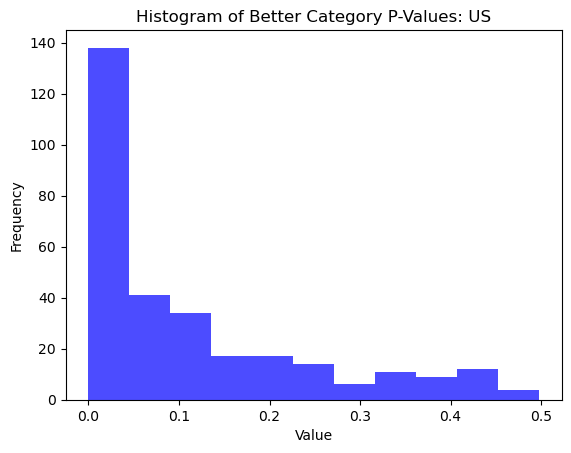

In [15]:

# Creating the histogram
plt.hist(res[0], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of Better Category P-Values: US')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


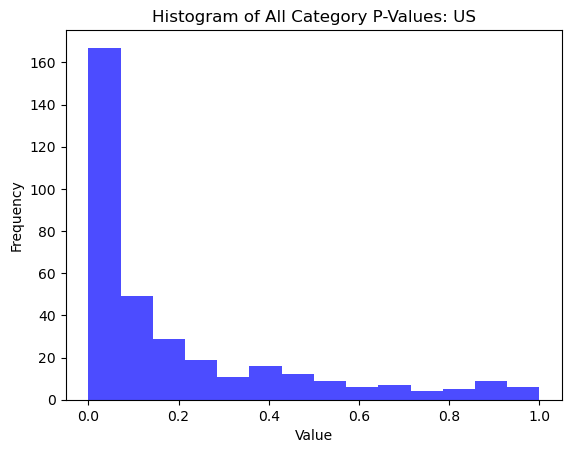

In [16]:

# Creating the histogram
plt.hist(res[1], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of All Category P-Values: US')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [17]:
def diebold_mariano_test_better_categories2(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if (np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn)) and (dm_statistic[1]<0.1):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Average P-value Better Categories: {np.mean(better_cats_pval)}')
    print(f'Average P-value All Categories: {np.mean(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [18]:
res2 = diebold_mariano_test_better_categories2(all_data_test_dict)

Number of Better Categories: 187
Total Categories: 349
Better Category %: 53.5817
Average P-value Better Categories: 0.029048868173232198
Average P-value All Categories: 0.19648865596568715


In [19]:
def diebold_mariano_test_better_categories2(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if (np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn)) and (dm_statistic[1]<0.05):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Average P-value Better Categories: {np.mean(better_cats_pval)}')
    print(f'Average P-value All Categories: {np.mean(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [20]:
res2 = diebold_mariano_test_better_categories2(all_data_test_dict)

Number of Better Categories: 144
Total Categories: 349
Better Category %: 41.2607
Average P-value Better Categories: 0.016068884823556322
Average P-value All Categories: 0.19648865596568715


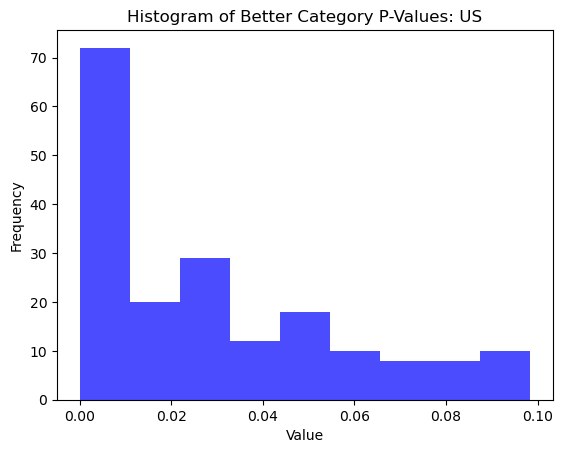

In [19]:
# Creating the histogram
plt.hist(res2[0], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of Better Category P-Values: US')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


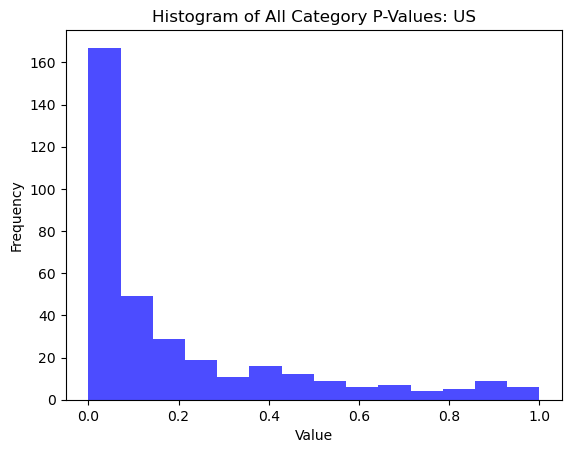

In [20]:

# Creating the histogram
plt.hist(res2[1], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of All Category P-Values: US')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


-------

In [21]:
def diebold_mariano_test(forecast_model1, forecast_model2, actual_values):
    # Calculate squared forecast errors for both models
    squared_errors_model1 = (forecast_model1 - actual_values)**2
    squared_errors_model2 = (forecast_model2 - actual_values)**2
    
    # Calculate Mean Squared Forecast Errors (MSFE) for both models
    msfe_model1 = np.mean(squared_errors_model1)
    msfe_model2 = np.mean(squared_errors_model2)
    
    # Calculate the difference in MSFE
    diff_msfe = msfe_model1 - msfe_model2
    
    # Calculate the variance of the difference
    var_diff = np.var(squared_errors_model1 - squared_errors_model2) / len(actual_values)
    
    # Calculate the Diebold-Mariano test statistic
    dm_statistic = diff_msfe / np.sqrt(var_diff)
    
    # Calculate the p-value
    p_value = 2 * (1 - norm.cdf(np.abs(dm_statistic)))  # Two-tailed test
    
    return dm_statistic, p_value

In [22]:
def diebold_mariano_test_all_categories(all_data_test_dict):
    list_of_squared_errors_bi_directional = []
    list_of_squared_errors_hrnn = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        # Calculate squared forecast errors for both models
        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        list_of_squared_errors_bi_directional.append(squared_errors_bi_directional)
        list_of_squared_errors_hrnn.append(squared_errors_hrnn)

    list_of_squared_errors_bi_directional = pd.concat(list_of_squared_errors_bi_directional)
    list_of_squared_errors_hrnn = pd.concat(list_of_squared_errors_hrnn)

    #print(f'num categories: {len(list(all_data_test_dict.keys()))}')
    #print(f'list of sqrd errors bi directional: {len(list_of_squared_errors_bi_directional)}')
    #print(f'list of sqrd errors: {len(list_of_squared_errors_hrnn)}')


    # Calculate Mean Squared Forecast Errors (MSFE) for both models
    msfe_bi_directional = np.mean(list_of_squared_errors_bi_directional)
    msfe_hrnn = np.mean(list_of_squared_errors_hrnn)
    
    # Calculate the difference in MSFE
    diff_msfe = msfe_bi_directional - msfe_hrnn

    # Calculate the variance of the difference
    var_diff = np.var(list_of_squared_errors_bi_directional - list_of_squared_errors_hrnn) / len(list_of_squared_errors_bi_directional)
    
    # Calculate the Diebold-Mariano test statistic
    dm_statistic = diff_msfe / np.sqrt(var_diff)
    
    # Calculate the p-value
    p_value = 2 * (1 - norm.cdf(np.abs(dm_statistic)))  # Two-tailed test
        
    return dm_statistic, p_value

In [23]:
dm_statistic, p_value = diebold_mariano_test_all_categories(all_data_test_dict)

alpha = 0.05  # Significance level (adjust as needed)

print("Diebold-Mariano Test Statistic:", dm_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("Conclusion: There is a statistically significant difference in predictive accuracy between the two models.")
else:
    print("Conclusion: There is no statistically significant difference in predictive accuracy between the two models.")


Diebold-Mariano Test Statistic: -11.379004492299233
p-value: 0.0
Conclusion: There is a statistically significant difference in predictive accuracy between the two models.


In [24]:
from dm_test import dm_test
dm_dict = {}
dm_dict_pvalues = {}

for category in list(all_data_test_dict.keys()):
#for category in ['Other lessons, courses and education services']:
    if category in ['Men’s and boys’ apparel', 'All items less shelter']:
        continue
    print(category)
    df = all_data_test_dict[category]
    actual_lst = df['Actual'].apply(lambda x: float(x)).tolist()
    bidirect_pred_lst = df['Bi-Directional Prediction'].apply(lambda x: float(x)).tolist()
    hrnn_pred_lst = df['HRNN Prediction'].apply(lambda x: float(x)).tolist()

    rt = dm_test(actual_lst ,bidirect_pred_lst, hrnn_pred_lst, h = 1, crit="MSE")
    p_value = rt[-1]

    dm_dict_pvalues[category] = p_value

    if p_value<= 0.01:
        dm_dict[category] = 1
    else:
        dm_dict[category] = 0


Admission to movies, theaters, and concerts
Bacon, breakfast sausage, and related products
Bread other than white
Canned fruits
Canned vegetables
Checking account and other bank services
Chicken
Cookies
Crackers, bread, and cracker products
Dried beans, peas, and lentils
Frankfurters
Fresh cakes and cupcakes
Fresh fish and seafood
Fresh sweetrolls, coffeecakes, doughnuts
Frozen and refrigerated bakery products, pies, tarts, turnovers
Frozen vegetables
Ham
Intracity mass transit
Lunchmeats
Oranges, including tangerines
Other condiments
Other pork including roasts and picnics
Other uncooked poultry including turkey
Parking fees and tolls
Pork chops
Prepared salads
Processed fish and seafood
Salt and other seasonings and spices
Sauces and gravies
Ship fare
Uncooked beef roasts
Uncooked beef steaks
Uncooked ground beef
Uncooked other beef and veal
Video discs and other media
White bread
Admissions
Airline fare
Apparel services other than laundry and dry cleaning
Apples
Bananas
Beef and vea

In [25]:
values = list(dm_dict.values())
print(f'p values < 0.01 count: {sum(values)}')
print(f'total count: {len(values)}')
print(f'percentage: %{round(100*sum(values)/len(values),3)}')

p values < 0.01 count: 52
total count: 347
percentage: %14.986


In [26]:
p_values = list(dm_dict_pvalues.values())

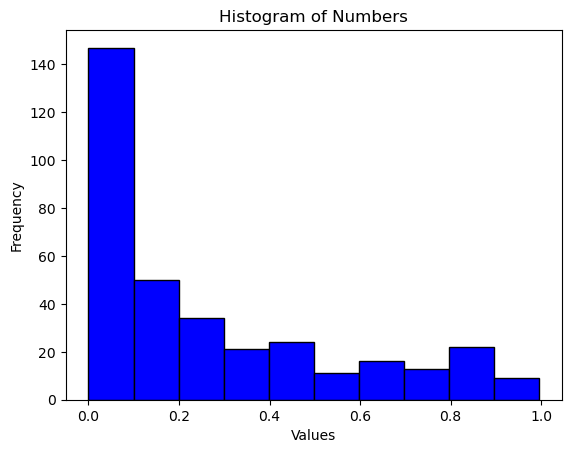

In [27]:
# Creating a histogram
plt.hist(p_values, bins=10, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Numbers')

# Display the histogram
plt.show()

In [28]:
# Define percentiles you want to calculate
percentiles = [10, 25, 50, 75, 90]

# Calculate percentiles using numpy.percentile
percentile_values = np.percentile(p_values, percentiles)

# Display the results
for p, value in zip(percentiles, percentile_values):
    print(f'{p}th percentile: {value}')

10th percentile: 0.005149914693998753
25th percentile: 0.03204479939770388
50th percentile: 0.14791921378894
75th percentile: 0.41793652686600014
90th percentile: 0.7713721791728326
